In [1]:

from mpdaf.obj import Cube
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d
from astropy import units as u
from numpy import ma
import numpy as np
from astropy.table import Table, Column, MaskedColumn, pprint
from astropy.io import fits
from astropy.wcs import WCS
from mpdaf.obj import Image
from scipy import integrate


In [2]:
# data array is read from the file (extension number 0)
cube = Cube(filename='/Users/s2537809/MUSE/cube_26.fits')

# The 3 dimensions of the cube:
print('Shape:', cube.shape)

print('Data Shape:', cube.data.shape)

#cube.var.shape - An optional numpy masked array of pixel variances, clearly not in this cube

print('Mask Shape:',cube.mask.shape)


# These output [k,p,q] where k is lamda 

Shape: (3722, 411, 409)
Data Shape: (3722, 411, 409)
Mask Shape: (3722, 411, 409)


In [3]:
with open('HST_ACS_HRC.F606W.dat', 'r') as file:
    HST = file.read()


# Split the data into lines
HST = HST.split('\n')

# Split each line into columns and filter out any lines that don't have 2 columns
rows = [row.split() for row in HST if len(row.split()) == 2]

HST_table = Table(rows=rows, names=['Wavelength', 'Throughput'])

HST_k = np.array(HST_table['Wavelength']).astype(float)
HST_w = np.array(HST_table['Throughput']).astype(float)

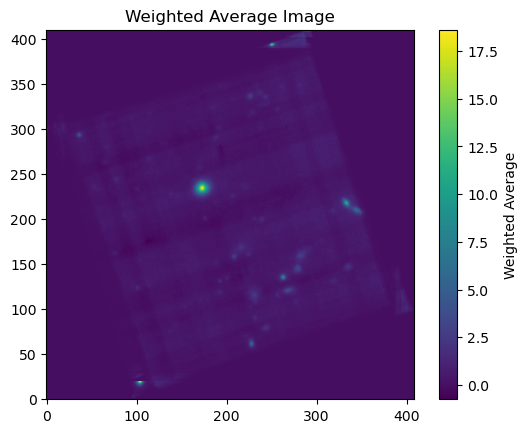

In [4]:
### Try with other cubes/ filters 


def filter_slice(cube, HST_k,HST_w):
    """    
    Parameters
    ----------
    cube : MUSE Cube 
        ....
    HST_k : numpy.ndarray
        HST Filter Wavelengths ...
    HST_w : numpy.ndarray
        HST Filter Throughputs to be used for weighting ...

    
    """
    # Find cube wavelengths and Flux arrays
    cube_k = cube.wave.coord()
    cube_flux = cube.data.data

    # Find the overlapping region
    overlap_start = max(np.min(cube_k), np.min(HST_k))
    overlap_end = min(np.max(cube_k), np.max(HST_k))

    # Truncate cube_k and HST_k to cover only the overlapping region
    cube_k_truncated = cube_k[(cube_k >= overlap_start) & (cube_k <= overlap_end)]
    cube_flux_truncated = cube_flux[(cube_k >= overlap_start) & (cube_k <= overlap_end), :,:]
    HST_w_truncated = HST_w[(HST_k >= overlap_start) & (HST_k <= overlap_end)]

    # Interpolate HST_w_truncated to match the shape of HST_k_interpolated
    HST_w_interpolated = np.interp(np.linspace(0, 1, len(cube_k_truncated)), np.linspace(0, 1, len(HST_w_truncated)), HST_w_truncated)

    # Get the shape of cube_flux_truncated
    shape = cube_flux_truncated.shape

    # Initialize an empty 2D array to store the weighted averages
    weighted_averages = np.zeros((shape[1], shape[2]))

    # Iterate over the spatial dimensions of cube_flux_truncated
    for i in range(shape[1]):  # iterate over the first spatial dimension
        for j in range(shape[2]):  # iterate over the second spatial dimension
            # Calculate the weighted average for the current pixel
            weighted_averages[i, j] = np.sum(cube_flux_truncated[:, i, j] * HST_w_interpolated) / np.sum(HST_w_interpolated)
             
    # Now weighted_averages contains the weighted average for each pixel up to (411, 409) in a 2D array
    
    return weighted_averages

weighted_averages = filter_slice(cube, HST_k, HST_w)

plt.imshow(weighted_averages, origin='lower', cmap='viridis')  # You can adjust the colormap as needed
plt.colorbar(label='Weighted Average')  # Add colorbar with label
plt.title('Weighted Average Image')  # Add title if needed
plt.show()



[-105.06171875 -104.26171875 -103.46171875 ... 2062.93828125 2063.73828125
 2064.53828125]
[-105 -104 -103 ... 2063 2064 2065]
Len(k): 2066
131
2713
Subcube k start: 4700.3271484375
Subcube k stop: 7281.5771484375


<function matplotlib.pyplot.figure(num: 'int | str | Figure | SubFigure | None' = None, figsize: 'tuple[float, float] | None' = None, dpi: 'float | None' = None, *, facecolor: 'ColorType | None' = None, edgecolor: 'ColorType | None' = None, frameon: 'bool' = True, FigureClass: 'type[Figure]' = <class 'matplotlib.figure.Figure'>, clear: 'bool' = False, **kwargs) -> 'Figure'>

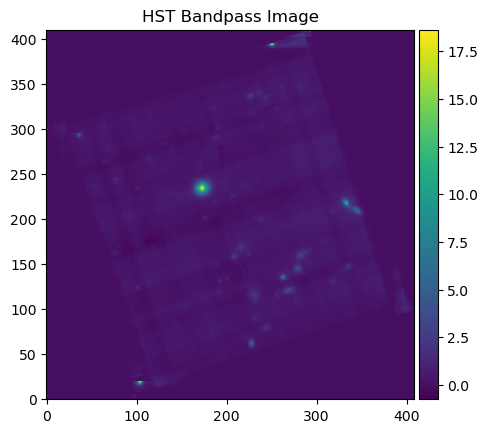

In [5]:
def bandpass_image(self, wavelengths, sensitivities, unit_wave=u.angstrom,
                       interpolation="linear"):
        """
        bandpass_image sums the images of a cube after multiplying the cube by a given spectral bandpass curve.
        
        
        Given a cube of images versus wavelength and the bandpass
        filter-curve of a wide-band monochromatic instrument, extract
        an image from the cube that has the spectral response of the
        monochromatic instrument.

        For example, this can be used to create a MUSE image that has
        the same spectral characteristics as an HST image. The MUSE
        image can then be compared to the HST image without having to
        worry about any differences caused by different spectral
        sensitivities.

        For each channel n of the cube, the filter-curve is integrated
        over the width of that channel to obtain a weight, w[n]. The
        output image is then given by the following weighted mean::

            output_image = sum(w[n] * cube_image[n]) / sum(w[n])

        In practice, to accommodate masked pixels, the w[n] array is
        expanded into a cube w[n,y,x], and the weights of individual
        masked pixels in the cube are zeroed before the above equation
        is applied.

        If the wavelength axis of the cube only partly overlaps the
        bandpass of the filter-curve, the filter curve is truncated to
        fit within the bounds of the wavelength axis. A warning is
        printed to stderr if this occurs, because this results in an
        image that lacks flux from some of the wavelengths of the
        requested bandpass.

        Parameters
        ----------
        wavelengths : numpy.ndarray
            An array of the wavelengths of the filter curve,
            listed in ascending order of wavelength. Outside
            the listed wavelengths the filter-curve is assumed
            to be zero.
        sensitivities : numpy.ndarray
            The relative flux sensitivities at the wavelengths
            in the wavelengths array. These sensititivies will be
            normalized, so only their relative values are important.
        unit_wave : `astropy.units.Unit`
            The units used in the array of wavelengths. The default is
            angstroms. To specify pixel units, pass None.
        interpolation : str
            The form of interpolation to use to integrate over the
            filter curve. This should be one of::

              "linear"     : Linear interpolation
              "cubic"      : Cubic spline interpolation (very slow)

            The default is linear interpolation. If the filter curve
            is well sampled and its sampling interval is narrower than
            the wavelength pixels of the cube, then this should be
            sufficient. Alternatively, if the sampling interval is
            significantly wider than the wavelength pixels of the
            cube, then cubic interpolation should be used instead.
            Beware that cubic interpolation is much slower than linear
            interpolation.

        Returns
        -------
        `~mpdaf.obj.Image`
            An image formed from the filter-weighted mean of channels in
            the cube that overlap the bandpass of the filter curve.

        """
        from scipy import integrate

        wavelengths = np.asarray(wavelengths, dtype=float)
        sensitivities = np.asarray(sensitivities, dtype=float)

        if (wavelengths.ndim != 1 or sensitivities.ndim != 1 or
                len(wavelengths) != len(sensitivities)):
            raise ValueError('The wavelengths and sensititivies arguments'
                             ' should be 1D arrays of equal length')

        if unit_wave is None:
            pixels = wavelengths.copy()
        else:
            pixels = self.wave.pixel(wavelengths, unit=unit_wave)

        # Get the integer indexes of the pixels that contain the above
        # floating point pixel indexes.
        print(pixels)
        indexes = np.rint(pixels).astype(int)
        print(indexes)

        # If there is no overlap between the bandpass filter curve
        # and the wavelength coverage of the cube, complain.
        if indexes[0] >= self.shape[0] or indexes[-1] < 0:
            raise ValueError("The filter curve does not overlap the "
                             "wavelength coverage of the cube.")

        # To correctly reproduce an image taken through a specified
        # filter, the bandpass curve should be completely encompassed
        # by the wavelength axis of the cube. If the overlap is
        # incomplete, emit a warning, then truncate the bandpass curve
        # to the edge of the wavelength range of the cube.
        if indexes[0] < 0 or indexes[-1] >= self.shape[0]:

            # Work out the start and stop indexes of the slice needed
            # to truncate the arrays of the bandpass filter curve.
            if indexes[0] < 0:
                start = np.searchsorted(indexes, 0, 'left')
            else:
                start = 0
            if indexes[-1] >= self.shape[0]:
                stop = np.searchsorted(indexes, self.shape[0], 'left')
            else:
                stop = indexes.shape[0]

            # Integrate the overal bandpass filter curve.
            total = integrate.trapz(sensitivities, wavelengths)

            # Also integrate over just the truncated parts of the curve.
            lost = 0.0
            if start > 0:
                s = slice(0, start)
                lost += integrate.trapz(sensitivities[s], wavelengths[s])
            if stop < indexes.shape[0]:
                s = slice(stop, indexes.shape[0])
                lost += integrate.trapz(sensitivities[s], wavelengths[s])

            # Compute the fraction of the integrated bandpass response
            # that has been truncated.
            lossage = lost / total

            # Truncate the bandpass filter curve.
            indexes = indexes[start:stop]
            pixels = pixels[start:stop]
            sensitivities = sensitivities[start:stop]

            # Report the loss if it is over 0.5%.
            if lossage > 0.005:
                self._logger.warning(
                    "%.2g%% of the integrated " % (lossage * 100.0) +
                    "filter curve is beyond the edges of the cube.")

        # Get the range of indexes along the wavelength axis that
        # encompass the filter bandpass within the cube.
        kmin = indexes[0]
        kmax = indexes[-1]
        print('Len(k):', kmax - kmin + 1) 
        print(start)
        print(stop)
        print('Subcube k start:', self.wave.coord(kmin))
        print('Subcube k stop:', self.wave.coord(kmax)) #  not sure this is actually how it is being used 
        
        


        # Obtain an interpolator of the bandpass curve.
        spline = interp1d(x=pixels, y=sensitivities,
                                      kind=interpolation)

        # Integrate the bandpass over the range of each spectral pixel
        # to determine the weights of each pixel. For the moment skip
        # the first and last pixels, which need special treatment.
        # Integer pixel indexes refer to the centers of pixels,
        # so for integer pixel index k, we need to integrate from
        # k-0.5 to k+0.5.
        w = np.empty((kmax + 1 - kmin))
        for k in range(kmin + 1, kmax):
            w[k - kmin], err = integrate.quad(spline, k - 0.5, k + 0.5)

        # Start the integration of the weight of the first channel
        # from the lower limit of the bandpass.
        w[0], err = integrate.quad(spline, pixels[0], kmin + 0.5)

        # End the integration of the weight of the final channel
        # at the upper limit of the bandpass.
        w[-1], err = integrate.quad(spline, kmax - 0.5, pixels[-1])

        # Normalize the weights.
        w /= w.sum()

        # Create a sub-cube of the selected channels.
        subcube = self[kmin:kmax + 1, :, :] 

        # To accommodate masked pixels, create a cube of the above
        # weights, but with masked pixels given zero weight.
        if subcube._mask is ma.nomask:
            wcube = w[:, np.newaxis, np.newaxis] * np.ones(subcube.shape)
        else:
            wcube = w[:, np.newaxis, np.newaxis] * ~subcube._mask

        # Get an image which is the sum of the weights along the spectral axis.
        wsum = wcube.sum(axis=0)

        # The output image is the weighted mean of the selected
        # channels. For each map pixel perform the following
        # calculation over spectral channels, k.
        #
        #  mean = sum(weights[k] * data[k]) / sum(weights[k]
        data = np.ma.sum(subcube.data * wcube, axis=0) / wsum

        # The variance of a weighted means is:
        #
        #  var = sum(weights[k]**2 * var[k]) / (sum(weights[k]))**2
        if subcube._var is not None:
            var = np.ma.sum(subcube.var * wcube**2, axis=0) / wsum**2
        else:
            var = False

        return Image.new_from_obj(subcube, data=data, var=var)




im4 = bandpass_image(cube, HST_table['Wavelength'], HST_table['Throughput']) ## Is the throughput actually good to use for sensitvities 



im4.plot(colorbar='v', title = 'HST Bandpass Image', )

plt.figure

In [6]:
from photutils.datasets import make_100gaussians_image
data = make_100gaussians_image()

In [7]:
from photutils.background import Background2D, MedianBackground
bkg_estimator = MedianBackground()
bkg = Background2D(data, (50, 50), filter_size=(3, 3),
                   bkg_estimator=bkg_estimator)
data -= bkg.background  # subtract the background


In [8]:
threshold = 1.5 * bkg.background_rms

In [9]:
from astropy.convolution import convolve
from photutils.segmentation import make_2dgaussian_kernel
kernel = make_2dgaussian_kernel(3.0, size=5)  # FWHM = 3.0
convolved_data = convolve(data, kernel)

In [10]:
from photutils.segmentation import detect_sources
segment_map = detect_sources(convolved_data, threshold, npixels=10)
print(segment_map)

<photutils.segmentation.core.SegmentationImage>
shape: (300, 500)
nlabels: 87
labels: [ 1  2  3  4  5 ... 83 84 85 86 87]


Text(0.5, 1.0, 'Segmentation Image')

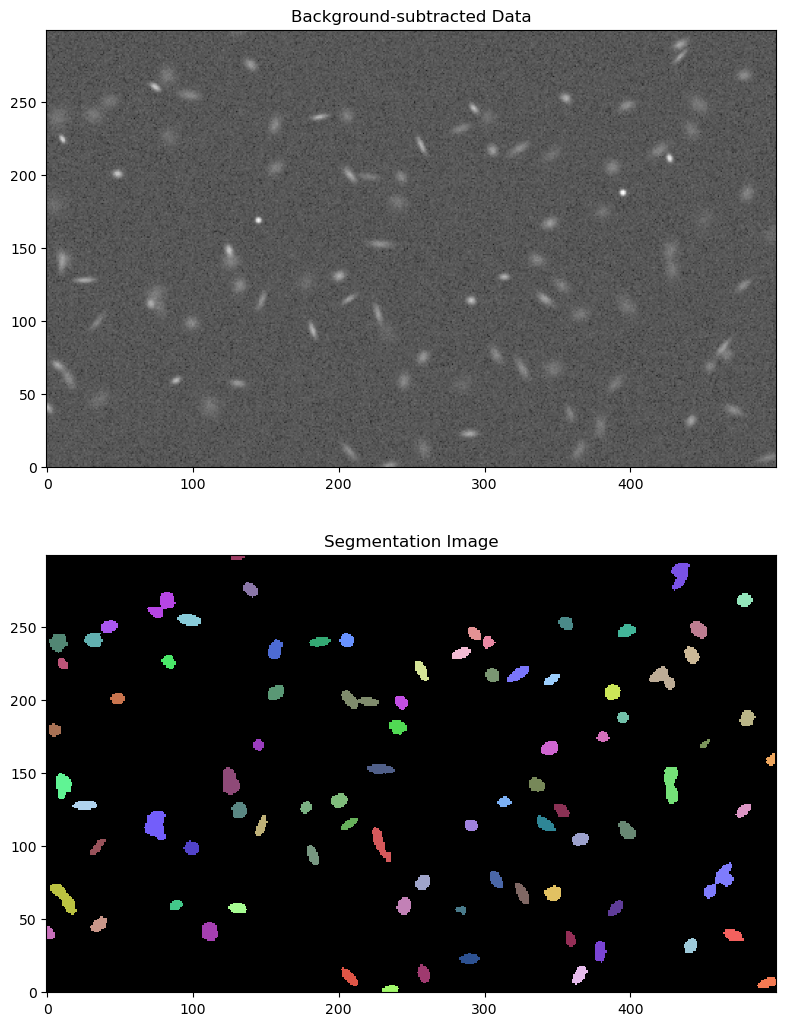

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
norm = ImageNormalize(stretch=SqrtStretch())
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12.5))
ax1.imshow(data, origin='lower', cmap='Greys_r', norm=norm)
ax1.set_title('Background-subtracted Data')
ax2.imshow(segment_map, origin='lower', cmap=segment_map.cmap,
           interpolation='nearest')
ax2.set_title('Segmentation Image')